In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer

In [13]:
df = pd.read_csv("../../data/contaminated/anomalieChatGpt.csv")
print("Total d'exemples :", len(df))
print(df['anomalous'].value_counts(), "\n")

Total d'exemples : 3419
anomalous
0    3077
1     342
Name: count, dtype: int64 



In [14]:
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
texts = df['modified_text'].tolist()
embeddings = sbert_model.encode(texts, batch_size=32, show_progress_bar=True)
print("Dimensions des embeddings :", embeddings.shape)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/107 [00:00<?, ?it/s]

Dimensions des embeddings : (3419, 384)


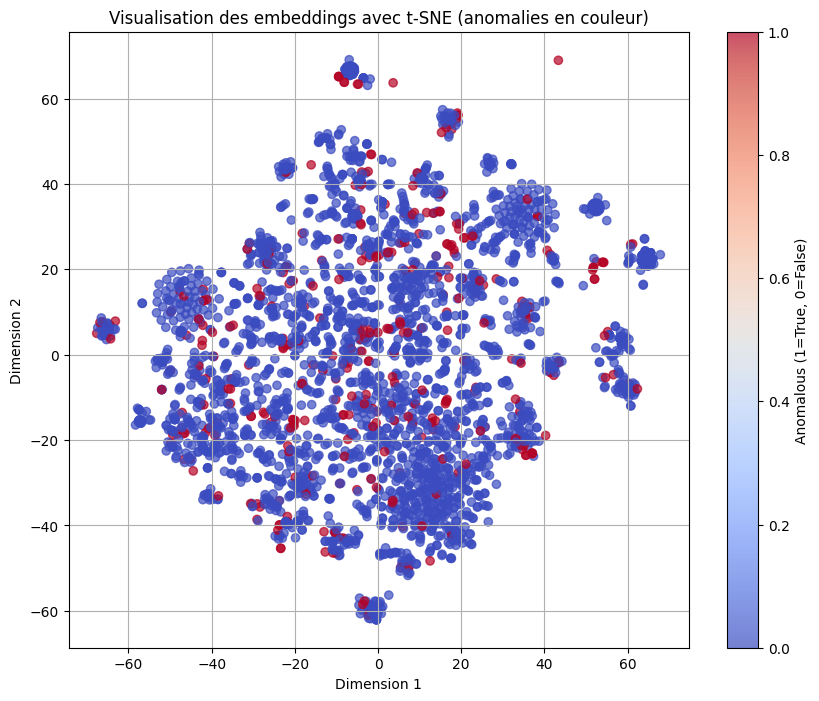

In [15]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
tsne = TSNE(n_components=2, random_state=42)
reduced_2d = tsne.fit_transform(embeddings)

# Visualisation
plt.figure(figsize=(10, 8))
plt.scatter(
    reduced_2d[:, 0],
    reduced_2d[:, 1],
    c=df["anomalous"],
    cmap='coolwarm',
    alpha=0.7
)
plt.title('Visualisation des embeddings avec t-SNE (anomalies en couleur)')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.colorbar(label='Anomalous (1=True, 0=False)')
plt.grid(True)
plt.show()


In [17]:
# Étiquettes vraies
y_true = df['anomalous'].values

In [32]:
original_indices = np.arange(len(scaled_embeddings))
X_train,X_test = train_test_split(scaled_embeddings, test_size=0.2, random_state=42)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, y_true, test_size=0.2, random_state=42, stratify=y_true
)
print("Taille train :", X_train.shape[0], " - Taille test :", X_test.shape[0])

Taille train : 2735  - Taille test : 684


In [19]:
# Pour l'Autoencodeur et One-Class SVM, on entraînera uniquement sur les données normales
X_train_normal = X_train[y_train == 0]

In [20]:
contamination = 0.10  # On attend environ 10% d'anomalies dans le train
iforest = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
iforest.fit(X_train)

IsolationForest(contamination=0.1, random_state=42)

In [21]:
# Obtenir les scores sur le jeu de test
scores_if_test = iforest.decision_function(X_test)
# Pour définir un seuil, on calcule le percentile des scores sur le train
thresh_if = np.percentile(iforest.decision_function(X_train), 100 * contamination)
# Prédiction : on considère comme anomalie si le score est inférieur au seuil
y_pred_if = (scores_if_test < thresh_if).astype(int)
print("Isolation Forest - anomalies détectées sur test :", y_pred_if.sum())


Isolation Forest - anomalies détectées sur test : 72


In [22]:
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.10)
# Entraînement uniquement sur les données normales du train
ocsvm.fit(X_train_normal)
# Obtenir les scores sur le test
scores_oc_test = ocsvm.decision_function(X_test)
# Définir le seuil à partir des scores sur le train normal
scores_oc_train = ocsvm.decision_function(X_train_normal)
thresh_oc = np.percentile(scores_oc_train, 100 * 0.10)
# Prédiction : anomalie si le score est inférieur au seuil
y_pred_oc = (scores_oc_test < thresh_oc).astype(int)
print("One-Class SVM - anomalies détectées sur test :", y_pred_oc.sum())


One-Class SVM - anomalies détectées sur test : 73


In [23]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Linear(hidden_dim, input_dim)
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

input_dim = embeddings.shape[1]
autoencoder = Autoencoder(input_dim, hidden_dim=128)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

# Entraîner l'autoencodeur sur les données normales du train uniquement
X_train_normal_tensor = torch.tensor(X_train_normal, dtype=torch.float32)
train_loader = DataLoader(TensorDataset(X_train_normal_tensor, X_train_normal_tensor),
                          batch_size=32, shuffle=True)

epochs = 20
autoencoder.train()
for epoch in range(1, epochs+1):
    total_loss = 0.0
    for batch_x, _ in train_loader:
        output = autoencoder(batch_x)
        loss = criterion(output, batch_x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch_x.size(0)
    avg_loss = total_loss / X_train_normal_tensor.size(0)
    if epoch % 5 == 0:
        print(f"Autoencodeur - Epoch {epoch}/{epochs} - Loss: {avg_loss:.6f}")

# Évaluer l'autoencodeur sur le jeu de test
autoencoder.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    recon_test = autoencoder(X_test_tensor)
errors_test = ((recon_test - X_test_tensor) ** 2).mean(dim=1).numpy()
# Pour l'autoencodeur, une erreur de reconstruction élevée indique une anomalie.
# On utilisera l'erreur directement (ou son opposé pour le ROC AUC).
scores_ae_test = -errors_test

# Pour définir le seuil, on calcule l'erreur sur les données normales du train
with torch.no_grad():
    recon_train = autoencoder(X_train_normal_tensor)
errors_train = ((recon_train - X_train_normal_tensor) ** 2).mean(dim=1).numpy()
thresh_ae = np.percentile(errors_train, 99)  # seuil à 99e percentile
# Prédiction : anomalie si l'erreur de reconstruction est supérieure au seuil
y_pred_ae = (errors_test > thresh_ae).astype(int)
print("Autoencodeur - anomalies détectées sur test :", y_pred_ae.sum())

Autoencodeur - Epoch 5/20 - Loss: 0.000320
Autoencodeur - Epoch 10/20 - Loss: 0.000212
Autoencodeur - Epoch 15/20 - Loss: 0.000173
Autoencodeur - Epoch 20/20 - Loss: 0.000153
Autoencodeur - anomalies détectées sur test : 15


In [24]:
# --- 7. Évaluation des performances ---
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Isolation Forest
precision_if = precision_score(y_test, y_pred_if)
recall_if    = recall_score(y_test, y_pred_if)
f1_if        = f1_score(y_test, y_pred_if)
roc_auc_if   = roc_auc_score(y_test, scores_if_test)

# One-Class SVM
precision_oc = precision_score(y_test, y_pred_oc)
recall_oc    = recall_score(y_test, y_pred_oc)
f1_oc        = f1_score(y_test, y_pred_oc)
roc_auc_oc   = roc_auc_score(y_test, scores_oc_test)

# Autoencodeur
precision_ae = precision_score(y_test, y_pred_ae)
recall_ae    = recall_score(y_test, y_pred_ae)
f1_ae        = f1_score(y_test, y_pred_ae)
roc_auc_ae   = roc_auc_score(y_test, scores_ae_test)


In [27]:
results = pd.DataFrame({
    "Modèle": ["Isolation Forest", "Autoencodeur", "One-Class SVM"],
    "Précision": [precision_if, precision_ae, precision_oc],
    "Rappel": [recall_if, recall_ae, recall_oc],
    "F1-score": [f1_if, f1_ae, f1_oc],
    "ROC AUC": [roc_auc_if, roc_auc_ae, roc_auc_oc]
}) 

print("\nTableau récapitulatif des performances :")
print(results)


Tableau récapitulatif des performances :
             Modèle  Précision    Rappel  F1-score   ROC AUC
0  Isolation Forest   0.069444  0.073529  0.071429  0.582983
1      Autoencodeur   0.066667  0.014706  0.024096  0.465479
2     One-Class SVM   0.054795  0.058824  0.056738  0.568659
